In [1]:
pip install mxnet

     |████████████████████████████████| 47.3 MB 1.6 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
pip install d2l

     |████████████████████████████████| 82 kB 513 kB/s 
     |████████████████████████████████| 61 kB 6.9 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 11.6 MB 49.2 MB/s 
     |████████████████████████████████| 9.9 MB 46.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the p

In [1]:
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

class Residual(nn.Block): 
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1,
                               strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1,
                                   strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def forward(self, X):
        Y = npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return npx.relu(Y + X)

In [2]:
blk = Residual(3)
blk.initialize()
X = np.random.uniform(size=(4, 3, 6, 6))
blk(X).shape

(4, 3, 6, 6)

In [3]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk.initialize()
blk(X).shape

(4, 6, 3, 3)

In [4]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [5]:
def resnet_block(num_channels, num_residuals, first_block=False):
    blk = nn.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

In [6]:
net.add(resnet_block(64, 2, first_block=True),
        resnet_block(128, 2),
        resnet_block(256, 2),
        resnet_block(512, 2))

In [7]:
net.add(nn.GlobalAvgPool2D(), nn.Dense(10))

In [8]:
X = np.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv5 output shape:	 (1, 64, 112, 112)
batchnorm4 output shape:	 (1, 64, 112, 112)
relu0 output shape:	 (1, 64, 112, 112)
pool0 output shape:	 (1, 64, 56, 56)
sequential1 output shape:	 (1, 64, 56, 56)
sequential2 output shape:	 (1, 128, 28, 28)
sequential3 output shape:	 (1, 256, 14, 14)
sequential4 output shape:	 (1, 512, 7, 7)
pool1 output shape:	 (1, 512, 1, 1)
dense0 output shape:	 (1, 10)


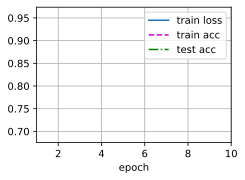

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())